In [1]:
import numpy as np
import pandas as pd

## Load Data

In [30]:
df_seq = pd.read_csv('pdb_data_seq.csv')
df_properties = pd.read_csv('pdb_data_no_dups.csv')
df_total = df_seq.merge(df_properties,left_on = 'structureId',right_on = 'structureId')

## Data Cleaning
- Select the data in top n by count, top 10 in our case
- Select only the protein sequences
- Select protein sequence with only one chain in the dataset

In [45]:
df_total=df_total[df_total['macromoleculeType_x'].isin(set(['Protein']))]
count = df_total['classification'].value_counts(dropna=False)[:10]
print(count)

HYDROLASE                        46336
TRANSFERASE                      36424
OXIDOREDUCTASE                   34322
IMMUNE SYSTEM                    15615
LYASE                            11682
HYDROLASE/HYDROLASE INHIBITOR    11218
TRANSCRIPTION                     8919
VIRAL PROTEIN                     8495
TRANSPORT PROTEIN                 8371
VIRUS                             6972
Name: classification, dtype: int64


In [48]:
df_selected = df_total[df_total['classification'].isin(set(count.index))]
df_selected = df_total[df_total['classification'].isin(set(count.index))]
df_selected = df_selected[df_selected['macromoleculeType_x'].isin(set(['Protein']))]
df_selected.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
67,117E,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,572,Protein,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0
68,117E,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,572,Protein,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0
76,11BA,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,248,Protein,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0
77,11BA,B,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,248,Protein,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0
78,11BG,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,248,Protein,HYDROLASE,X-RAY DIFFRACTION,Protein,248,1.90,30391.41,NaN,NaN,2.40,48.68,pH 4.8,4.8,1999.0


## Pearson Correlation Matrix
### We want to get a better understanding of the correlations between the physical attributes by building a Pearson Correlation Matrix. A value closer to 1 represents a higher correlation between the two factors, and further from 1 represents a lower correlation between the two factors.
- Reduce the dataset to only numerical column and clssification column
- We are only using the top 10 classification classes

In [49]:
class_dict = {'HYDROLASE':1, 'TRANSFERASE':2, 'OXIDOREDUCTASE':3, 'IMMUNE SYSTEM':4, 'LYASE':5,
              'HYDROLASE/HYDROLASE INHIBITOR':6, 'TRANSCRIPTION':7, 'VIRAL PROTEIN':8,
              'TRANSPORT PROTEIN':9, 'VIRUS':10}
df_selected['class'] = df_selected.classification.map(class_dict)
columns = ['residueCount_x', 'resolution', 'structureMolecularWeight', 'densityMatthews',
           'densityPercentSol', 'publicationYear', 'class']
df_ml = df_selected[columns]
# drop the nulls
df_ml.dropna(inplace=True)
df_ml.head()

C:\Users\liyij\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,residueCount_x,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,publicationYear,class
67,572,2.15,65203.21,2.71,54.69,1998.0,1
68,572,2.15,65203.21,2.71,54.69,1998.0,1
76,248,2.06,28700.28,2.48,50.36,1998.0,1
77,248,2.06,28700.28,2.48,50.36,1998.0,1
78,248,1.90,30391.41,2.40,48.68,1999.0,1


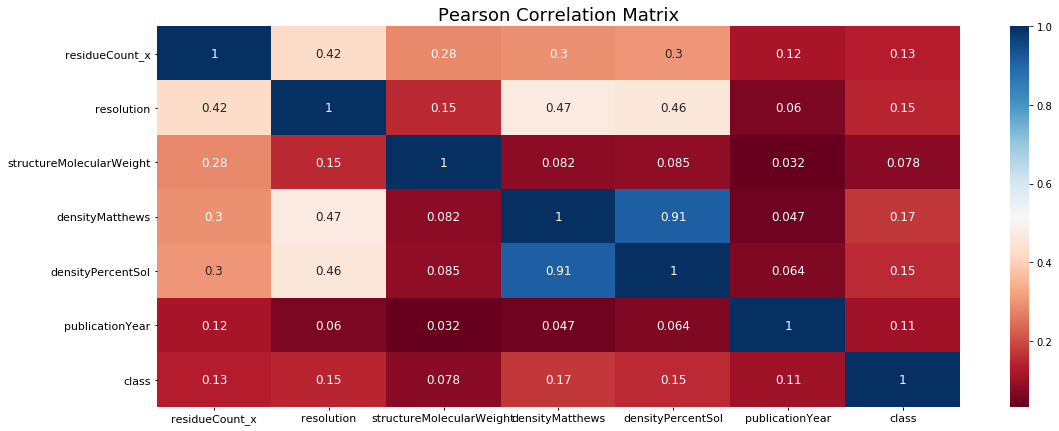

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns
colormap = plt.cm.RdBu
f, ax = plt.subplots(figsize=(18,7))
sns.heatmap(df_ml.corr(), cmap= colormap, annot=True, ax=ax, annot_kws ={'fontsize':12})
kwargs = {'length':2.5, 'width':1, 'colors':'black', 'labelsize':11}
ax.tick_params(**kwargs)
ax.tick_params(**kwargs, axis='x')
plt.title ('Pearson Correlation Matrix', color = 'black', fontsize=18)

plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df_ml.drop('class',axis = 1)
y = df_ml['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Standardizing the dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\liyij\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\liyij\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\liyij\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\liyij\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


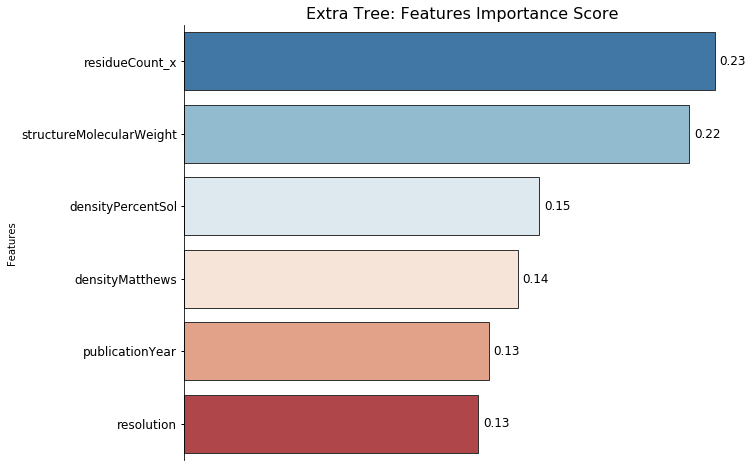

In [ ]:
data = test_df
#need to remove nulls
data = data.dropna()
print(data.shape)
print(data.head())
X_train, X_test,y_train,y_test = \
train_test_split(data['resolution'], data['classification'], test_size = 0.2, random_state = 1)

In [ ]:
#vectorize data, prepare for building models
#Convert a collection of text documents to a matrix of token counts
#seems has nothing to do with sequence but only with the frequency

#ngram is a parameter we need to focus on, 

#vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (3,3))
vect = CountVectorizer(analyzer = 'char_wb')

# Fit and Transform CountVectorizer
#occasionally may meet np.nan error
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#to store the results for different mothods
prediction = dict()

In [ ]:
model = ExtraTreesClassifier()
model.fit(X_train_df,y_train)

In [ ]:
X = data.iloc[:,1:4]  #independent columns
y = data.iloc[:,0]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(3).plot(kind='barh')
plt.show()